# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import *

import missingno as msno

In [2]:
# Setting up a random seed for connsistency
RANDOM_SEED = 42

# Load train and test data into dataframes 

In [4]:
train = pd.read_csv('../data/train.csv').drop(['id'],axis=1)
test = pd.read_csv('../data/test.csv').drop(['id'],axis=1)
print(f'Train data shape: {train.shape}, Test data shape: {test.shape}')

Train data shape: (28322, 35), Test data shape: (85065, 34)


# Data clean up

In [5]:
# Print the data types
print(train.dtypes)

gender     object
s11        object
s12        object
s13         int64
s16        object
s17        object
s18        object
s48         int64
s52        object
s53        object
s54        object
s55        object
s56       float64
s57       float64
s58        object
s59       float64
s69        object
s70        object
s71        object
n1        float64
n2        float64
n3          int64
n4        float64
n5        float64
n6        float64
n7        float64
n8        float64
n9        float64
n10       float64
n11       float64
n12         int64
n13         int64
n14       float64
n15         int64
label       int64
dtype: object


<AxesSubplot:>

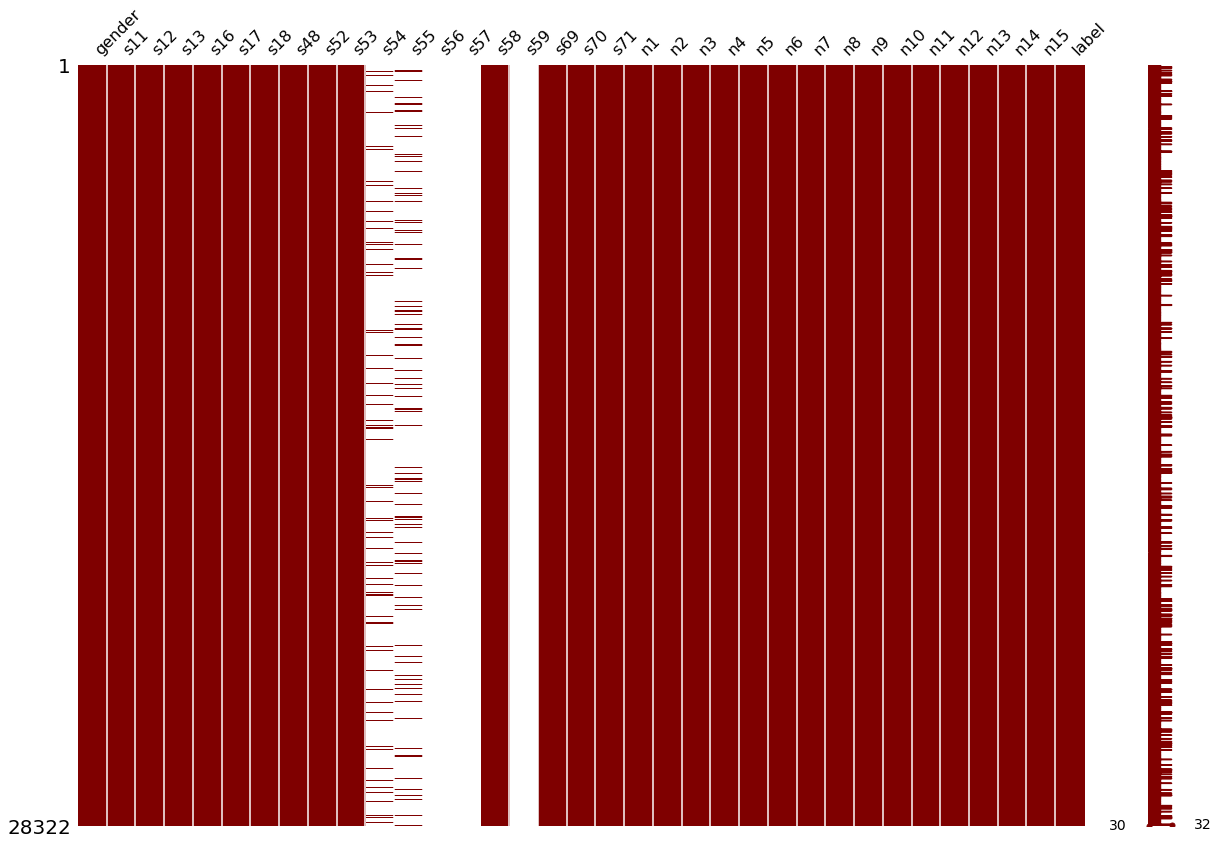

In [6]:
# Plot a map of missing values
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

In [7]:
print('Percentage of missing values in train data')
for i in np.arange(train.shape[1]):
    n = train.iloc[:,i].isnull().sum() 
    if n > 0:
        print(list(train.columns.values)[i] + ': ' + str((n/train.shape[0])*100) + '% nans')
print('Percentage of missing values in train data')
for i in np.arange(test.shape[1]):
    n = test.iloc[:,i].isnull().sum() 
    if n > 0:
        print(list(test.columns.values)[i] + ': ' + str((n/test.shape[0])*100) + ' nans')

Percentage of missing values in train data
s54: 90.72099428006497% nans
s55: 88.68017795353435% nans
s56: 100.0% nans
s57: 100.0% nans
s59: 100.0% nans
Percentage of missing values in train data
s54: 90.89754893316875 nans
s55: 88.92493975195438 nans
s56: 100.0 nans
s57: 100.0 nans
s59: 100.0 nans


The columns 's56', 's57', 's59' are completely emnpty and more than 80% samples in columns 's54' and 's55' have missing values. So these  columns will be removed for now.

In [8]:
# Dropping empty columns
train = train.drop(['s54','s55','s56','s57','s59'], axis=1)
test = test.drop(['s54','s55','s56','s57','s59'], axis=1)

## Change string data into categorical values 

In [9]:
for i in range(train.shape[1]):
    if train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(train.iloc[:,i].values) + list(test.iloc[:,i].values))
        train.iloc[:,i] = lbl.transform(list(train.iloc[:,i].values))
        test.iloc[:,i] = lbl.transform(list(test.iloc[:,i].values))

# Classification

### Splitting train data into train/test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('label',axis=1), train['label'],
                                                    test_size=0.2, random_state=RANDOM_SEED, shuffle=True,
                                                   stratify=train['label'])

In [11]:
cv = KFold(n_splits=2, random_state=RANDOM_SEED, shuffle=True)

### Defining a Random Forest Classifier that will print out scores along with feature importances

In [12]:
def randomForest(X_train, y_train, X_test, y_test):
    RF = RandomForestClassifier(random_state=RANDOM_SEED)
    output = cross_validate(RF, X_train, y_train, cv=cv,
                            scoring = ['roc_auc'], n_jobs=-1, return_estimator =True)
    dfc = pd.DataFrame(output)
    print("RF cross-validation AUC: {}".format(dfc['test_roc_auc'].mean(axis=0)))
    
    for idx,estimator in enumerate(output['estimator']):
        test_scores = []
        y_pred = estimator.predict(X_test)
        test_scores.append(roc_auc_score(y_test, y_pred))
        print(f'Test AUC: {sum(test_scores)/len(test_scores)}')
        
        perm_importance = permutation_importance(estimator, X_test, y_test)

        feature_names = X_train.columns
        features = np.array(feature_names)

        sorted_idx = perm_importance.importances_mean.argsort()
        f, ax = plt.subplots(figsize=(11, 9))
        sns.barplot(x=perm_importance.importances_mean[sorted_idx], y=features[sorted_idx], orient='h')
        ax.set_xlabel("feature importance")
        plt.tight_layout()
        plt.show()
        break

RF cross-validation AUC: 0.8594877892631922
Test AUC: 0.6950193189943068


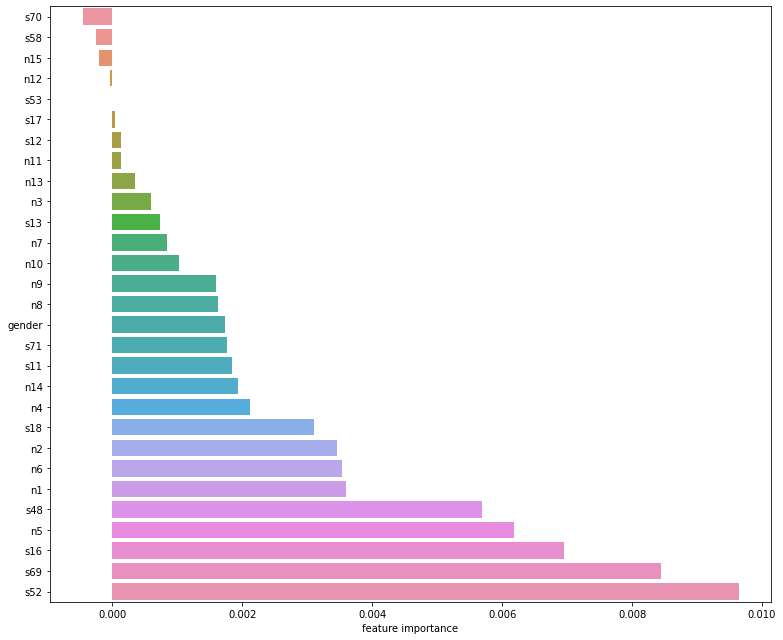

In [13]:
randomForest(X_train, y_train, X_test, y_test)

In [19]:
def xgb(X_train, y_train, X_test, y_test, test):
    XGB = XGBClassifier(random_state=RANDOM_SEED)
    output = cross_validate(XGB, X_train, y_train, cv=cv,
                            scoring = ['roc_auc'], n_jobs=-1, return_estimator =True)
    dfc = pd.DataFrame(output)
    print("RF cross-validation AUC: {}".format(dfc['test_roc_auc'].mean(axis=0)))
    test_scores = []
    test_df = pd.DataFrame()
    for idx,estimator in enumerate(output['estimator']):
        y_pred = estimator.predict(X_test)
        test_scores.append(roc_auc_score(y_test, y_pred))
        print(f'Test AUC: {sum(test_scores)/len(test_scores)}')
        
        test_pred = estimator.predict(test)
        test_df = pd.concat([test_df, pd.Series(test_pred)], axis=1)
        label = test_df.median(axis=1).astype(int)
        
        perm_importance = permutation_importance(estimator, X_test, y_test)

        feature_names = X_train.columns
        features = np.array(feature_names)

        sorted_idx = perm_importance.importances_mean.argsort()
        f, ax = plt.subplots(figsize=(11, 9))
        sns.barplot(x=perm_importance.importances_mean[sorted_idx], y=features[sorted_idx], orient='h')
        ax.set_xlabel("feature importance")
        plt.tight_layout()
        plt.show()
        break

RF cross-validation AUC: 0.8504613973441328
Test AUC: 0.6924365067478296


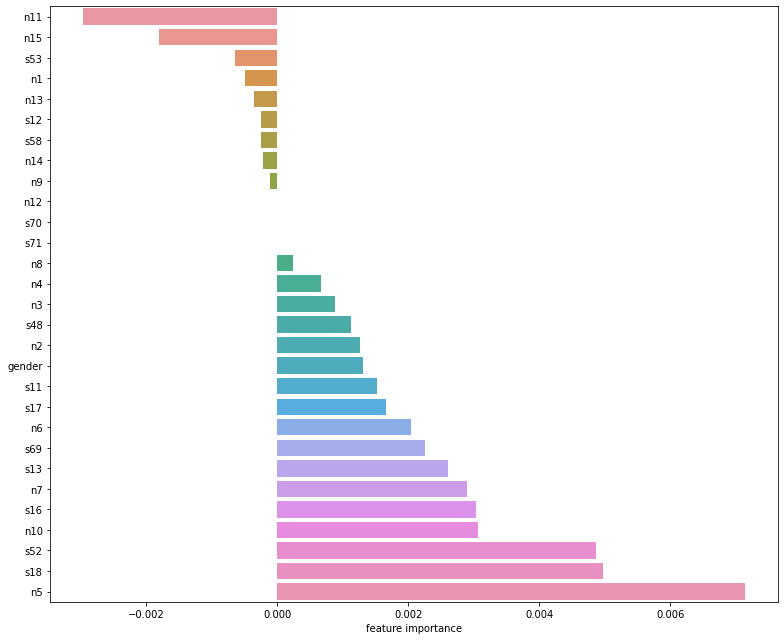

In [20]:
xgb(X_train, y_train, X_test, y_test, test)

In [21]:
xgb = XGBClassifier(random_state=RANDOM_SEED)
param_grid= {
    'max_depth': [4,10,16],
    'subsample': [0.3, 0.5, 1],
    'gamma': [0.5, 1],
    'min_child_weight': [1,5],
    'eta': [0.01, 0.05],
    'num_parallel_tree': [1,5]
}

In [22]:
CV_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv= cv,\
                    verbose=3, n_jobs=-1, scoring='roc_auc', return_train_score=False)

In [23]:
CV_xgb.fit(X_train, y_train)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


GridSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraint...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.01, 0.05], 'gamma': [0.5, 1],
                         'max_depth': [4, 10, 16], 'min_child_weight': [1, 5],
                         'num_parallel_tree': [1, 5],
                         'subsample': [0.3, 0.5, 1]},
             scoring='roc_auc', verbose=3)

In [24]:
y_pred = CV_xgb.predict(X_test)
score = roc_auc_score(y_test,y_pred)
score

0.7115614864660059

In [25]:
test_pred = CV_xgb.predict(test)
# test_df = pd.concat([test_df, pd.Series(test_pred)], axis=1)
# label = test_df.median(axis=1).astype(int)
submission = pd.concat([test_copy['id'],pd.Series(test_pred)],axis=1)
submission.columns = ['id', 'label']

NameError: name 'test_copy' is not defined

In [26]:
CV_xgb.best_params_

{'eta': 0.05,
 'gamma': 0.5,
 'max_depth': 4,
 'min_child_weight': 1,
 'num_parallel_tree': 5,
 'subsample': 0.3}

In [27]:
xgbc = XGBClassifier(random_state=RANDOM_SEED,
                    eta=0.05,
                    gamma=0.5,
                    max_depth=10,
                    min_child_weight=5,
                    num_parallel_tree=5,
                    subsample=0.5)

In [28]:
xgbc.fit(X_train,y_train)
y_pred=xgbc.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7108398101442995

In [30]:
testid = pd.read_csv('../data/test.csv')
test_pred = xgbc.predict(test)
submission = pd.concat([testid['id'],pd.Series(test_pred)],axis=1)
submission.columns = ['id', 'label']
submission.to_csv('submission_2.csv', index=False)

In [34]:
import multiprocessing
n_jobs = multiprocessing.cpu_count()-1
n_jobs

11

In [32]:
!nvidia-smi

Fri Jun 10 15:13:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.59       Driver Version: 512.59       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:26:00.0  On |                  N/A |
|  0%   49C    P8    16W / 125W |   1349MiB /  6144MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------